<a href="https://colab.research.google.com/github/fireball412/colab_experiments/blob/main/keras_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a Simple TensorFlow Lite for Microcontrollers model

## Configure Defaults

In [ ]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Setup Environment

Install Dependencies

In [2]:
! pip install tensorflow==2.4.0rc0

     |████████████████████████████████| 394.7MB 41kB/s 
     |████████████████████████████████| 1.3MB 50.2MB/s 
     |████████████████████████████████| 460kB 43.1MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


Import Dependencies

In [2]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

## Dataset

### 1. Import Data

In [3]:
from google.colab import files 


uploaded = files.upload()


Saving Explorer-2020-11-28.csv to Explorer-2020-11-28.csv


In [7]:
import pandas as pd 
import io 

df = pd.read_csv(io.BytesIO(uploaded['Explorer-2020-11-28.csv'])) 
print(df)


             Date          Time  RSSI(dB)  ...  SH                 LSW  TxBat(V)
0      2020-11-28  13:12:43.310         0  ...  -1  0x0000000000000000      10.0
1      2020-11-28  13:12:43.380         0  ...  -1  0x0000000000000000      10.0
2      2020-11-28  13:12:43.480         0  ...  -1  0x0000000000000000      10.0
3      2020-11-28  13:12:43.580         0  ...  -1  0x0000000000000000      10.0
4      2020-11-28  13:12:43.680         0  ...  -1  0x0000000000000000      10.0
...           ...           ...       ...  ...  ..                 ...       ...
16932  2020-11-28  18:27:36.930         0  ...  -1  0x0000000000000000      10.0
16933  2020-11-28  18:27:37.030         0  ...  -1  0x0000000000000000      10.0
16934  2020-11-28  18:27:37.130         0  ...  -1  0x0000000000000000      10.0
16935  2020-11-28  18:27:37.230         0  ...  -1  0x0000000000000000      10.0
16936  2020-11-28  18:27:37.330         0  ...  -1  0x0000000000000000      10.0

[16937 rows x 26 columns]


https://towardsdatascience.com/extract-rows-columns-from-a-dataframe-in-python-r-678e5b6743d6

In [55]:
print(df.iloc[0])

Date                2020-11-28
Time              13:12:43.310
RSSI(dB)                     0
RxBt(V)                      0
Cels(V)                      0
Curr(A)                      0
Cap(mAh)                  1378
Rud                         -2
Ele                          2
Thr                      -1021
Ail                         11
S1                        -732
S2                         341
S3                         379
LS                        -450
RS                        -135
SA                           0
SB                           0
SC                           0
SD                           0
SE                           0
SF                           1
SG                           0
SH                          -1
LSW         0x0000000000000000
TxBat(V)                    10
Name: 0, dtype: object


[-1022 -1022 -1022 ... -1018 -1018 -1018]
[0.5 0.5 0.5 ... 0.2 0.2 0.2]
[   7    7    8 ... 1362 1362 1362]


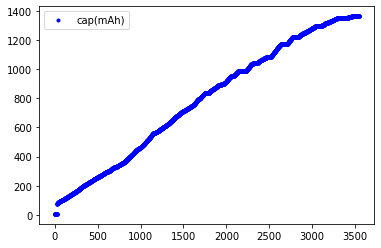

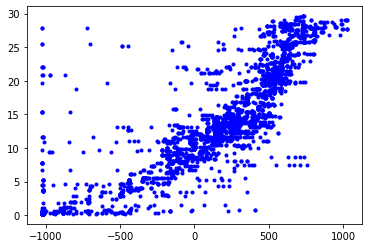

In [70]:
#x_valuestest = np.random.uniform(low=0, high=2*math.pi, size=10).astype(np.float32)
index_start=2385
index_stop=5931

#throttle 
x_values=df.iloc[index_start:index_stop,9]
x_values=x_values.to_numpy() 
print(x_values)

#current
y_values=df.iloc[index_start:index_stop,5]
y_values=y_values.to_numpy() 
print(y_values)

#cap(mAh)
y_values2=df.iloc[index_start:index_stop,6]
y_values2=y_values2.to_numpy() 
print(y_values2)

# Plot capacity
plt.plot(y_values2, 'b.', label="cap(mAh)")
plt.legend()
plt.show()

# Plot current vs. throttle
plt.plot(x_values, y_values, 'b.')
plt.show()

### 2. Split the Data
We now have a dataset that approximates real world data. We'll be using this to train our model.

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing) It's important in both cases that we use fresh data that was not already used to train the model.

The data is split as follows:

Training: 60%
Validation: 20%
Testing: 20%
The following code will split our data and then plots each set as a different color: